In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Milestone 3 EDA

Group members: Josh Feldman, Mariah Barber, Simon Sebbagh, Daniel Janini

## Cleaning the census data

In [2]:
# Read the census data
df_census = pd.read_csv("../../data/census/census_zipcode_level.csv")
df_census.head()

,Zip,State,Population,White,Black,Native,Asian,Islander,Other,Two,...,Families,Married_couple_families,Married_couple_child_under_18,Married_couple_no_child_under_18,Single_parent_families,Single_parent_child_under_18,Single_parent_no_child_under_18,Non_families,Househoulder_living_alone,Householder_living_with_unrelated
0,35004,Alabama,10418,8495,1657,0,198,0,0,42,...,3031,2265,820,1445,766,351,415,1194,1090,104
1,35005,Alabama,7708,4432,3130,2,0,2,0,26,...,2103,1540,530,1010,563,229,334,824,707,117
2,35006,Alabama,3099,2849,205,9,0,0,0,15,...,857,675,261,414,182,73,109,332,314,18
3,35007,Alabama,26630,19673,3210,0,251,10,28,416,...,6680,5457,2533,2924,1223,604,619,2055,1802,253
4,35010,Alabama,20826,12247,7048,93,203,0,0,327,...,5605,3586,1088,2498,2019,1121,898,2302,2112,190


In [3]:
df_census["Zip"].describe()

count    32989.000000
mean     49860.474279
std      27446.550091
min       1001.000000
25%      27107.000000
50%      49839.000000
75%      72176.000000
max      99929.000000
Name: Zip, dtype: float64

We need to convert the zip codes to strings. We also need to replace the 0s that were cut off in the conversion to integers.

In [4]:
# Make a column of the three digit zip codes
def make_three_dig_zip(x):
    while len(x) < 5:
        x = '0'+x
    return x[:3]

df_census['Zip_clean'] = (df_census['Zip']
                          .astype(str)
                          .apply(make_three_dig_zip))
df_census.head()

,Zip,State,Population,White,Black,Native,Asian,Islander,Other,Two,...,Married_couple_families,Married_couple_child_under_18,Married_couple_no_child_under_18,Single_parent_families,Single_parent_child_under_18,Single_parent_no_child_under_18,Non_families,Househoulder_living_alone,Householder_living_with_unrelated,Zip_clean
0,35004,Alabama,10418,8495,1657,0,198,0,0,42,...,2265,820,1445,766,351,415,1194,1090,104,350
1,35005,Alabama,7708,4432,3130,2,0,2,0,26,...,1540,530,1010,563,229,334,824,707,117,350
2,35006,Alabama,3099,2849,205,9,0,0,0,15,...,675,261,414,182,73,109,332,314,18,350
3,35007,Alabama,26630,19673,3210,0,251,10,28,416,...,5457,2533,2924,1223,604,619,2055,1802,253,350
4,35010,Alabama,20826,12247,7048,93,203,0,0,327,...,3586,1088,2498,2019,1121,898,2302,2112,190,350


Now we need to create our protected class proportions.

In [5]:
# Calculate the total number of males and females
df_census['female_allAges'] = df_census['Female_0to9_Years'] + df_census['Female_10to19_Years'] + df_census['Female_20to29_Years'] + df_census['Female_30to39_Years'] + df_census['Female_40to49_Years'] + df_census['Female_50to59_Years'] + df_census['Female_60to69_Years'] + df_census['Female_70p_Years']
df_census['male_allAges'] = df_census['Male_0to9_Years'] + df_census['Male_10to19_Years'] + df_census['Male_20to29_Years'] + df_census['Male_30to39_Years'] + df_census['Male_40to49_Years'] + df_census['Male_50to59_Years'] + df_census['Male_60to69_Years'] + df_census['Male_70p_Years']

# Calculate the total number of older adults (>60)
df_census['OlderPop'] = df_census['Female_60to69_Years'] + df_census['Female_70p_Years'] + df_census['Male_60to69_Years'] + df_census['Male_70p_Years']

Let's check to make sure our race classes add up to the population

In [19]:
race_cols = ['White', 'Black', 'Native', 'Asian','Islander', 'Other', 'Two', 'Hispanic']
all(df_census[race_cols].sum(axis = 1) - df_census.Population == 0)

True

In [15]:
df_threeDigZipDemography = pd.DataFrame(columns=['Zip',
                                                 'WhitePct',
                                                 'BlackPct',
                                                 'NativePct',
                                                 'AsianPct',
                                                 'IslanderPct',
                                                 'HispanicPct',
                                                 'MalePct',
                                                 'FemalePct',
                                                 'OlderPct'])

zip_list = df_census['Zip_clean'].unique()

# Calculate the percent of race,gender,and age variables for each three digit zip code
for cZip in zip_list:
    df_temp = df_census[df_census['Zip_clean']==cZip]
    total_population = df_temp['Population'].sum()

    total_white = df_temp['White'].sum()
    white_pct = total_white / total_population

    total_black = df_temp['Black'].sum()
    black_pct = total_black / total_population

    total_native = df_temp['Native'].sum()
    native_pct = total_native / total_population

    total_asian = df_temp['Asian'].sum()
    asian_pct = total_asian / total_population

    total_islander = df_temp['Islander'].sum()
    islander_pct = total_islander / total_population

    total_Hispanic = df_temp['Hispanic'].sum()
    hispanic_pct = total_Hispanic / total_population

    total_male = df_temp['male_allAges'].sum()
    male_pct = total_male / total_population

    total_female = df_temp['female_allAges'].sum()
    female_pct = total_female / total_population

    total_older = df_temp['OlderPop'].sum()
    older_pct = total_older / total_population

    df_threeDigZipDemography = df_threeDigZipDemography.append({'Zip':cZip, 'WhitePct':white_pct, 'BlackPct':black_pct,
                                                               'NativePct':native_pct, 'AsianPct':asian_pct, 'IslanderPct':islander_pct,
                                                                'HispanicPct':hispanic_pct, 'MalePct':male_pct, 'FemalePct':female_pct,
                                                                'OlderPct':older_pct}, ignore_index=True)


/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: R

In [16]:
df_threeDigZipDemography.head()

,Zip,WhitePct,BlackPct,NativePct,AsianPct,IslanderPct,HispanicPct,MalePct,FemalePct,OlderPct
0,350,0.727181,0.209815,0.003025,0.006738,0.000081,0.038006,0.489275,0.510725,0.219173
1,351,0.794534,0.139405,0.002746,0.006510,0.000117,0.043007,0.488275,0.511725,0.215490
2,352,0.486085,0.433222,0.001135,0.021972,0.000418,0.041916,0.472644,0.527356,0.197089
3,354,0.583614,0.358224,0.001564,0.014737,0.000203,0.031375,0.480424,0.519576,0.183694
4,355,0.904833,0.051246,0.002031,0.003438,0.000117,0.022525,0.489146,0.510854,0.261412


## Prepare Lending Data

We need to load the lending data and merge it with the demographic information

In [120]:
# load data
accepted_df = pd.read_csv("../../data/rawData/full/fullAccepted.csv", error_bad_lines=False)
rejected_df = pd.read_csv("../../data/rawData/full/fullRejected.csv", error_bad_lines=False)

b'Skipping line 42537: expected 145 fields, saw 289\n'
b'Skipping line 85073: expected 145 fields, saw 289\n'
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
#get accepted zip codes
accepted_df = accepted_df[['zip_code','int_rate', 'loan_status']]
accepted_df['zip_code'] = accepted_df['zip_code'].astype(str).apply(lambda x: x[:3])
accepted_df['int_rate'] = accepted_df['int_rate'].astype(str).apply(lambda x: x.replace("%", "")).astype(float)
accepted_df.head()

,zip_code,int_rate,loan_status
0,860,10.65,Fully Paid
1,309,15.27,Charged Off
2,606,15.96,Fully Paid
3,917,13.49,Fully Paid
4,972,12.69,Fully Paid


In [122]:
# get rejected zip codes
rejected_zip = rejected_df['Zip Code'].astype(str).apply(lambda x: x[:3])
rejected_zip.head()

0    481
1    010
2    212
3    017
4    209
Name: Zip Code, dtype: object

In [123]:
# merge demographics with zip codes
accepted_demographics = pd.merge(accepted_df, 
                                 df_threeDigZipDemography, 
                                 how = 'left',
                                 left_on = 'zip_code',
                                 right_on = 'Zip'
                                )
df_AcceptedDemography = accepted_demographics[accepted_demographics.Zip.notna()]

rejected_demographics = pd.merge(pd.DataFrame(rejected_zip), 
                                 df_threeDigZipDemography, 
                                 how = 'left',
                                 left_on = 'Zip Code',
                                 right_on = 'Zip'
                                )
df_RejectedDemography = rejected_demographics[rejected_demographics.Zip.notna()]

In [124]:
df_AcceptedDemography.head()

,zip_code,int_rate,loan_status,Zip,WhitePct,BlackPct,NativePct,AsianPct,IslanderPct,HispanicPct,MalePct,FemalePct,OlderPct
0,860,10.65,Fully Paid,860,0.465812,0.012975,0.349176,0.013854,0.001335,0.130637,0.499913,0.500087,0.152583
1,309,15.27,Charged Off,309,0.449882,0.453978,0.001385,0.025975,0.001243,0.047180,0.484299,0.515701,0.194018
2,606,15.96,Fully Paid,606,0.324396,0.304727,0.001184,0.060433,0.000181,0.291173,0.485628,0.514372,0.161613
3,917,13.49,Fully Paid,917,0.198788,0.036672,0.002378,0.228690,0.002190,0.511622,0.494760,0.505240,0.180698
4,972,12.69,Fully Paid,972,0.721732,0.047241,0.004530,0.077848,0.005978,0.098654,0.493164,0.506836,0.187969


In [125]:
df_RejectedDemography.head()

,Zip Code,Zip,WhitePct,BlackPct,NativePct,AsianPct,IslanderPct,HispanicPct,MalePct,FemalePct,OlderPct
0,481,481,0.788061,0.095019,0.002402,0.044706,0.000185,0.043047,0.489598,0.510402,0.204688
1,010,010,0.820283,0.024454,0.001096,0.030039,0.000328,0.106660,0.482270,0.517730,0.228364
2,212,212,0.432490,0.452644,0.002528,0.037763,0.000464,0.049728,0.470943,0.529057,0.199302
3,017,017,0.790369,0.025197,0.000834,0.080720,0.000209,0.073266,0.488300,0.511700,0.208260
4,209,209,0.315254,0.288248,0.001435,0.105451,0.000731,0.253772,0.480077,0.519923,0.198656


## Underwriting: Accepted vs. Rejected Loan Applications

We will explore the accepted vs rejected datasets.

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


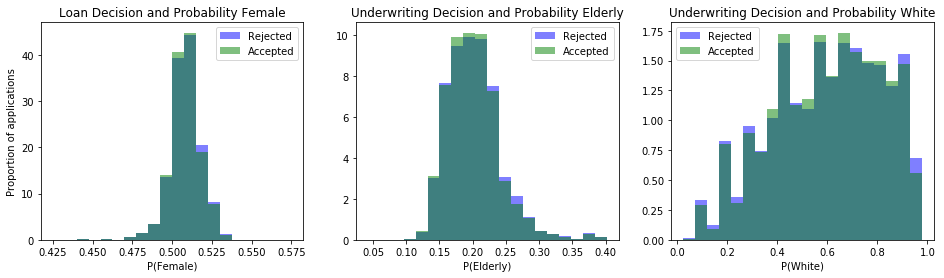

In [126]:
# Make histogram plots of accepted vs rejected by protected class
fig, axs = plt.subplots(1, 3,figsize=(16,4))
fig.subplots_adjust(wspace=0.2)

axs[0].hist(df_RejectedDemography['FemalePct'],range=[0.425, 0.575],alpha=0.5,bins = 20,density=True,color='blue',label='Rejected')
axs[0].hist(df_AcceptedDemography['FemalePct'],range=[0.425, 0.575],alpha=0.5,bins = 20,density=True,color='green',label='Accepted')
axs[0].set_title('Loan Decision and Probability Female')
axs[0].set_xlabel('P(Female)')
axs[0].set_ylabel('Proportion of applications')
axs[0].legend()
axs[0].grid(False)

df_RejectedDemography['OlderPct'].hist(alpha=0.5,density=True,color='blue',bins = 20,label='Rejected', ax = axs[1])
df_AcceptedDemography['OlderPct'].hist(alpha=0.5,density=True,color='green',bins = 20,label='Accepted', ax = axs[1])
axs[1].set_title('Underwriting Decision and Probability Elderly')
axs[1].set_xlabel('P(Elderly)')
# axs[1].set_ylabel('Proportion of applications')
axs[1].legend()
axs[1].grid(False)

df_RejectedDemography['WhitePct'].hist(alpha=0.5,density=True,color='blue',bins = 20, label='Rejected', ax = axs[2])
df_AcceptedDemography['WhitePct'].hist(alpha=0.5,density=True,color='green',bins = 20,label='Accepted', ax = axs[2])
axs[2].set_title('Underwriting Decision and Probability White')
axs[2].set_xlabel('P(White)')
# axs[2].set_ylabel('Proportion of applications')
axs[2].legend()
axs[2].grid(False)

plt.savefig("../../figs/EDA/accepted_rejected_stat_parity")
plt.show()


## Risk Score

We will use interest rate as a proxy for the risk calculated by lendingclub's models. To calculate statistical parity, we will plot interest rates across the proportion of protected class.

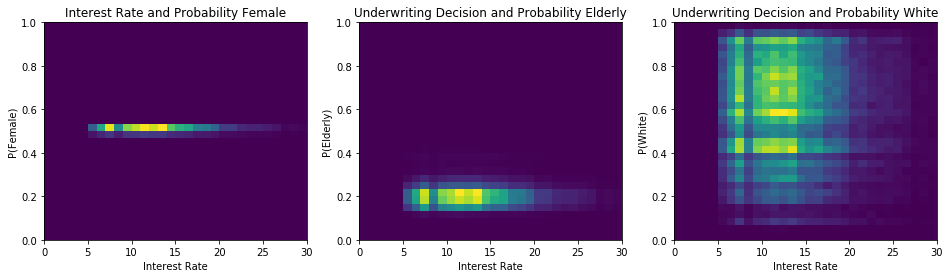

In [127]:
# Make histogram plots of accepted vs rejected by protected class
fig, axs = plt.subplots(1, 3,figsize=(16,4))
fig.subplots_adjust(wspace=0.2)

df_sample = df_AcceptedDemography.sample(100000)
axs[0].hist2d(df_sample.int_rate, df_sample.FemalePct, bins = 30, range = [[0, 30], [0, 1]])
axs[0].set_title('Interest Rate and Probability Female')
axs[0].set_xlabel('Interest Rate')
axs[0].set_ylabel('P(Female)')
axs[0].grid(False)

axs[1].hist2d(df_sample.int_rate, df_sample.OlderPct, bins = 30, range = [[0, 30], [0, 1]])
axs[1].set_title('Underwriting Decision and Probability Elderly')
axs[1].set_xlabel('Interest Rate')
axs[1].set_ylabel('P(Elderly)')
axs[1].grid(False)

axs[2].hist2d(df_sample.int_rate, df_sample.WhitePct, bins = 30, range = [[0, 30], [0, 1]])
axs[2].set_title('Underwriting Decision and Probability White')
axs[2].set_xlabel('Interest Rate')
axs[2].set_ylabel('P(White)')
axs[2].grid(False)

plt.savefig("../../figs/EDA/risk_stat_parity")
plt.show()

## Loan Status

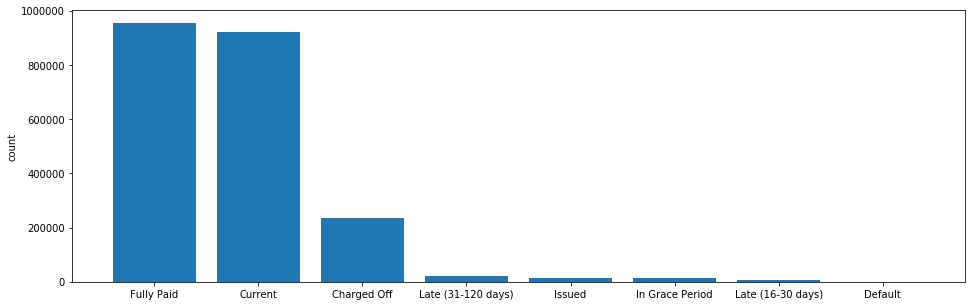

In [145]:
plt.figure(figsize=(16, 5))
counts = accepted_df.loan_status.value_counts()
plt.bar(range(len(counts)), counts, tick_label = counts.index)
plt.ylabel('count')
plt.savefig("../../figs/EDA/loan_type_count")